# Wavefunction Approximation 

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle

from ANFISpy import ANFIS

# Grid 200

Load data.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

gridsize = 200

with open(f"data_{gridsize}/{gridsize}_data.pkl", "rb") as f:
    data = pickle.load(f)

gx, gy = data['gx'].ravel(), data['gy'].ravel()

x = np.stack((gx, gy), axis=1)
y = data['ps'].ravel()

SEED = 42

x, index = np.unique(x, axis=0, return_index=True)
y = y[index]

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.15, random_state=SEED)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.1, random_state=SEED)

x_train = torch.tensor(x_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
x_test = torch.tensor(x_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)
x_val = torch.tensor(x_val, dtype=torch.float32, device=device)
y_val = torch.tensor(y_val, dtype=torch.float32, device=device)

x_train_mean = x_train.mean(dim=0)
x_test_mean = x_test.mean(dim=0)
x_val_mean = x_val.mean(dim=0)
x_train_std = x_train.std(dim=0)
x_test_std = x_test.std(dim=0)
x_val_std = x_val.std(dim=0)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std
x_val = (x_val - x_val_mean) / x_val_std

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

cpu


## Sigmoid

Load model.

In [3]:
n_vars = 2
mf_names = [['Low', 'Medium', 'High']]
mfshape = 'sigmoid'

variables = {
    'inputs': {
        'n_sets': [3, 3],
        'uod': n_vars * [(-3, 3)],
        'var_names': ['X', 'Y'],
        'mf_names': n_vars * mf_names,
    },
    'output': {
        'var_names': 'P',
        'n_classes': 1,
    },
}

anfis = ANFIS(
    variables,
    mfshape,
    and_operator=torch.prod,
    output_activation=nn.Identity(),
)

model = torch.load(f'data_{gridsize}/{mfshape}_{gridsize}.pth', map_location=device, weights_only=True)
anfis.load_state_dict(model)

<All keys matched successfully>

Plotting.

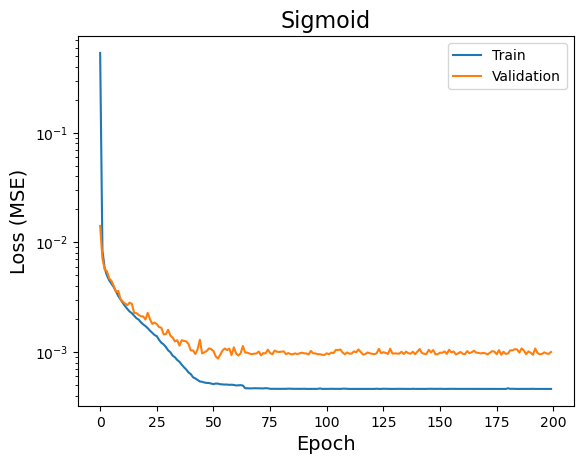

In [4]:
train_losses = np.load(f'data_{gridsize}/train_{mfshape}_{gridsize}.npy')
val_losses = np.load(f'data_{gridsize}/val_{mfshape}_{gridsize}.npy')

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.yscale('log')
plt.legend()
plt.title('Sigmoid', fontsize=16)
plt.show()

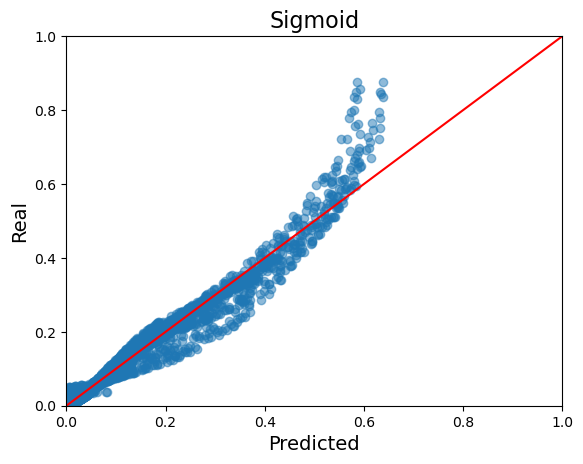

In [5]:
y_pred = torch.abs(anfis(x_test))

plt.scatter(y_pred.detach().cpu(), y_test.detach().cpu(), alpha=0.5)
plt.plot([0, 1], [0, 1], color='red')
plt.ylabel('Real', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.title('Sigmoid', fontsize=16)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

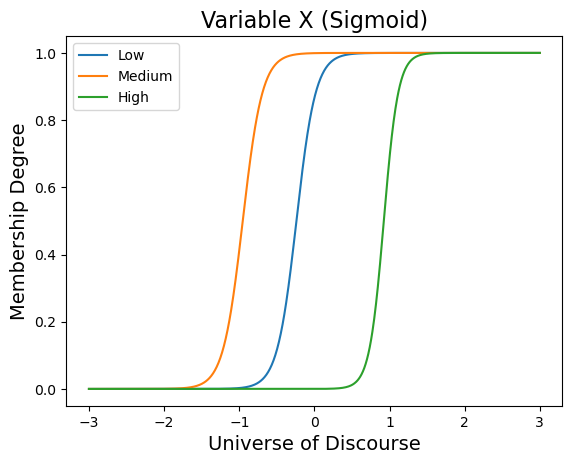

In [6]:
var_name = 'X'

var_index = anfis.input_var_names.index(var_name)
n_sets = anfis.input_n_sets[var_index]
uod = torch.linspace(-3, 3, 1000).to(device)
mf_names = anfis.input_mf_names[var_index]
mf_function = anfis.memberships[var_index]

memberships = mf_function(uod)

for i in range(n_sets):
    plt.plot(uod.cpu().numpy(), memberships[:, i].detach().cpu().numpy(), label=f'{mf_names[i]}')

plt.title(f'Variable {var_name} (Sigmoid)', fontsize=16)
plt.xlabel('Universe of Discourse', fontsize=14)
plt.ylabel('Membership Degree', fontsize=14)
plt.legend()
plt.show()

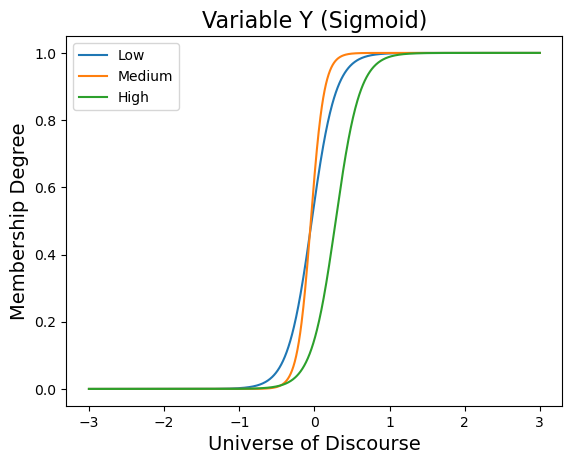

In [7]:
var_name = 'Y'

var_index = anfis.input_var_names.index(var_name)
n_sets = anfis.input_n_sets[var_index]
uod = torch.linspace(-3, 3, 1000).to(device)
mf_names = anfis.input_mf_names[var_index]
mf_function = anfis.memberships[var_index]

memberships = mf_function(uod)

for i in range(n_sets):
    plt.plot(uod.cpu().numpy(), memberships[:, i].detach().cpu().numpy(), label=f'{mf_names[i]}')

plt.title(f'Variable {var_name} (Sigmoid)', fontsize=16)
plt.xlabel('Universe of Discourse', fontsize=14)
plt.ylabel('Membership Degree', fontsize=14)
plt.legend()
plt.show()

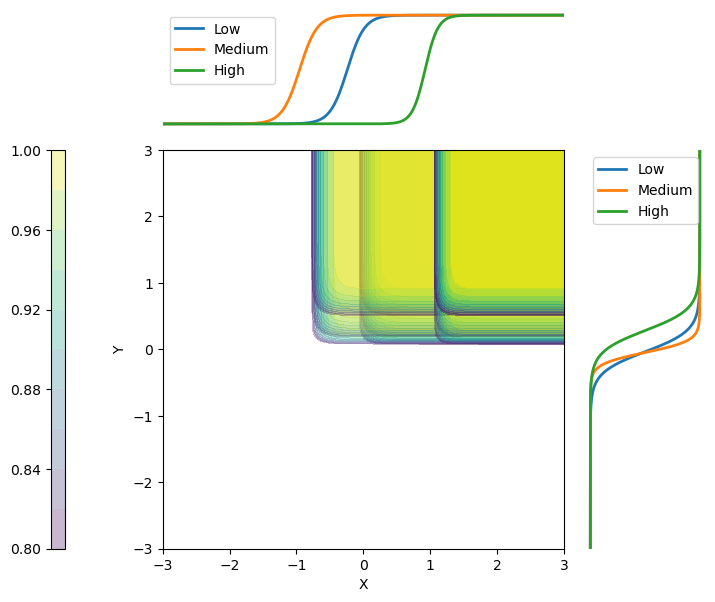

In [8]:
var_names = ['X', 'Y']
n_points=1000
thr=0.8
levels=10
cmap='viridis'
alpha=0.3
x_data=None
y_data=None
file_name=None

var_index = anfis.input_var_names.index(var_names[0])
n_sets0 = anfis.input_n_sets[var_index]
uod0 = torch.linspace(*anfis.input_uod[var_index], n_points).to(device)
mf_names0 = anfis.input_mf_names[var_index]
mf_function0 = anfis.memberships[var_index]

memberships0 = mf_function0(uod0)

var_index = anfis.input_var_names.index(var_names[1])
n_sets1 = anfis.input_n_sets[var_index]
uod1 = torch.linspace(*anfis.input_uod[var_index], n_points).to(device)
mf_names1 = anfis.input_mf_names[var_index]
mf_function1 = anfis.memberships[var_index]

memberships1 = mf_function1(uod1)

x = np.linspace(uod0[0].cpu(), uod0[-1].cpu(), n_points)
y = np.linspace(uod1[0].cpu(), uod1[-1].cpu(), n_points)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(2, 2, width_ratios=[5, 1.5], height_ratios=[1.5, 5], wspace=0.08, hspace=0.08)

ax_main = fig.add_subplot(gs[1, 0])
ax_top = fig.add_subplot(gs[0, 0])
ax_right = fig.add_subplot(gs[1, 1])

for i in range(n_sets0):
    for j in range(n_sets1):
        if anfis.and_operator == torch.prod:
            Z = np.outer(memberships1[:, j].detach().cpu().numpy(), memberships0[:, i].detach().cpu().numpy())
        elif anfis.and_operator == torch.min:
            Z = np.minimum.outer(memberships1[:, j].detach().cpu().numpy(), memberships0[:, i].detach().cpu().numpy())
        Z[Z < thr] = np.nan
        ax_main.contourf(X, Y, Z, levels=levels, cmap=cmap, alpha=alpha)

ax_main.set_xlabel(var_names[0])
ax_main.set_ylabel(var_names[1])

cbar_ax = fig.add_axes([ax_main.get_position().x0 - 0.16,
                ax_main.get_position().y0,
                0.02,
                ax_main.get_position().height])

cbar = fig.colorbar(ax_main.contourf(X, Y, Z, levels=levels, cmap=cmap, alpha=alpha), cax=cbar_ax, orientation="vertical")

cbar.ax.yaxis.set_ticks_position("left")
cbar.ax.yaxis.set_label_position("left")

for i in range(n_sets0):
    ax_top.plot(uod0.cpu(), memberships0[:, i].detach().cpu().numpy(), label=f'{mf_names0[i]}', lw=2)

ax_top.legend()
ax_top.set_xticks([])
ax_top.set_yticks([])

for i in range(n_sets1):
    ax_right.plot(memberships1[:, i].detach().cpu().numpy(), uod1.cpu(), label=f'{mf_names1[i]}', lw=2)

ax_right.legend()
ax_right.set_xticks([])
ax_right.set_yticks([])

ax_top.set_xlim(ax_main.get_xlim())
ax_right.set_ylim(ax_main.get_ylim())

ax_top.set_frame_on(False)
ax_right.set_frame_on(False)

plt.show()

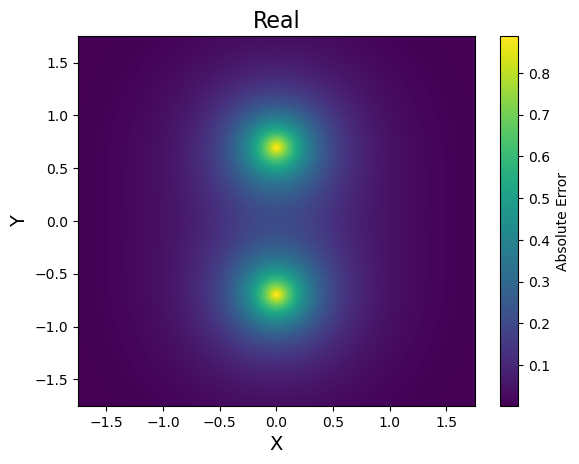

In [9]:
with open(f"data_{gridsize}/{gridsize}_data.pkl", "rb") as f:
    data = pickle.load(f)

gx, gy = data['gx'].ravel(), data['gy'].ravel()

x = np.stack((gx, gy), axis=1)
y = data['ps'].ravel()

SEED = 42

x, index = np.unique(x, axis=0, return_index=True)
y = y[index]

xplot = torch.tensor(x, dtype=torch.float32)
yplot = torch.tensor(y, dtype=torch.float32)

xplot_mean = xplot.mean(dim=0)
xplot_std = xplot.std(dim=0)

xplot = (xplot - xplot_mean) / xplot_std

xi = np.linspace(xplot[:, 0].min(), xplot[:, 0].max(), gridsize)
yi = np.linspace(xplot[:, 1].min(), xplot[:, 1].max(), gridsize)
X, Y = np.meshgrid(xi, yi)

Z_real = y.reshape(gridsize, gridsize)

plt.imshow(Z_real, extent=[-1.75, 1.75, -1.75, 1.75], origin='lower', aspect='auto')
plt.colorbar(label="Absolute Error")
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.title('Real', fontsize=16)
plt.show()

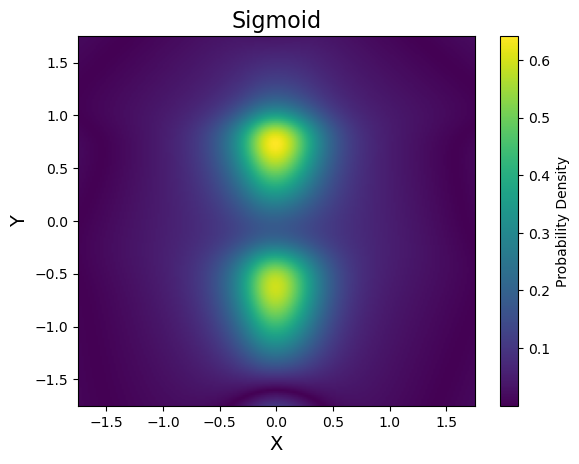

In [10]:
y = anfis(xplot).detach().squeeze()

xi = np.linspace(xplot[:, 0].min(), xplot[:, 0].max(), gridsize)
yi = np.linspace(xplot[:, 1].min(), xplot[:, 1].max(), gridsize)
X, Y = np.meshgrid(xi, yi)

Z_sig = np.abs(y.reshape(gridsize, gridsize).detach().numpy())

plt.imshow(Z_sig, extent=[-1.75, 1.75, -1.75, 1.75], origin='lower', aspect='auto')
plt.colorbar(label="Probability Density")
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.title('Sigmoid', fontsize=16)
plt.show()

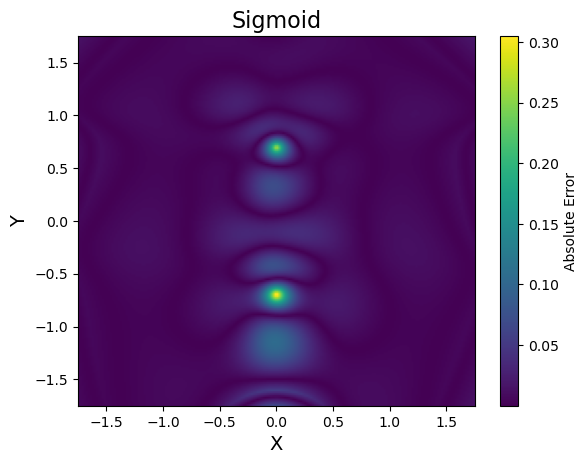

In [11]:
error_sig = np.abs(Z_real - Z_sig)

plt.imshow(error_sig, extent=[-1.75, 1.75, -1.75, 1.75], origin='lower', aspect='auto')
plt.colorbar(label="Absolute Error")
plt.title('Sigmoid', fontsize=16)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.show()

## Gaussian

Loading model.

In [12]:
n_vars = 2
mf_names = [['Low', 'Medium', 'High']]
mfshape = 'gaussian'

variables = {
    'inputs': {
        'n_sets': [3, 3],
        'uod': n_vars * [(-3, 3)],
        'var_names': ['X', 'Y'],
        'mf_names': n_vars * mf_names,
    },
    'output': {
        'var_names': 'P',
        'n_classes': 1,
    },
}

anfis = ANFIS(
    variables,
    mfshape,
    and_operator=torch.prod,
    output_activation=nn.Identity(),
)

model = torch.load(f'data_{gridsize}/{mfshape}_{gridsize}.pth', map_location=device, weights_only=True)
anfis.load_state_dict(model)

<All keys matched successfully>

Plotting.

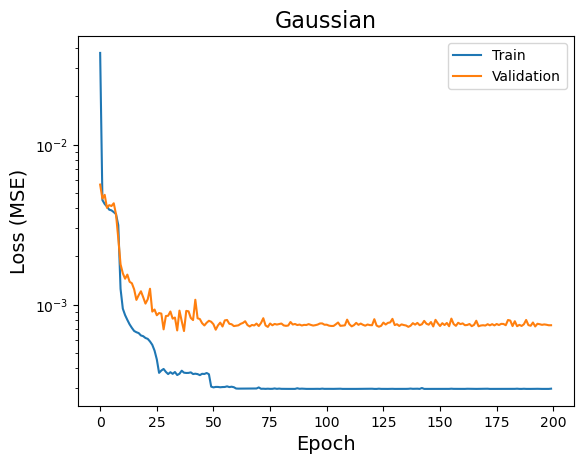

In [13]:
train_losses = np.load(f'data_{gridsize}/train_{mfshape}_{gridsize}.npy')
val_losses = np.load(f'data_{gridsize}/val_{mfshape}_{gridsize}.npy')

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.yscale('log')
plt.legend()
plt.title('Gaussian', fontsize=16)
plt.show()

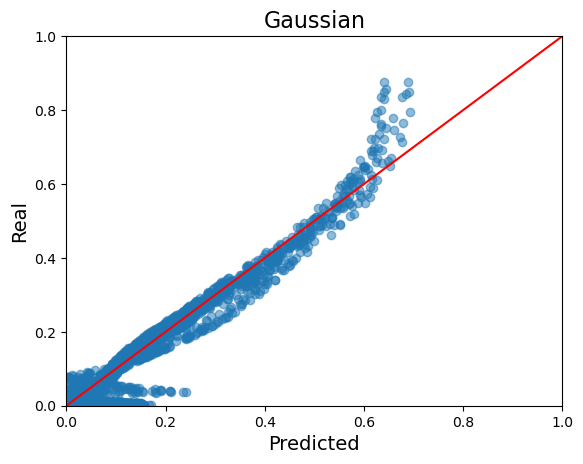

In [14]:
y_pred = torch.abs(anfis(x_test))

plt.scatter(y_pred.detach().cpu(), y_test.detach().cpu(), alpha=0.5)
plt.plot([0, 1], [0, 1], color='red')
plt.ylabel('Real', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.title('Gaussian', fontsize=16)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

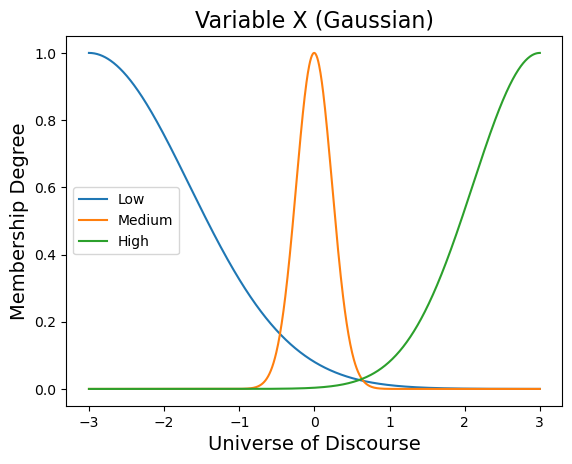

In [15]:
var_name = 'X'

var_index = anfis.input_var_names.index(var_name)
n_sets = anfis.input_n_sets[var_index]
uod = torch.linspace(-3, 3, 1000).to(device)
mf_names = anfis.input_mf_names[var_index]
mf_function = anfis.memberships[var_index]

memberships = mf_function(uod)

for i in range(n_sets):
    plt.plot(uod.cpu().numpy(), memberships[:, i].detach().cpu().numpy(), label=f'{mf_names[i]}')

plt.title(f'Variable {var_name} (Gaussian)', fontsize=16)
plt.xlabel('Universe of Discourse', fontsize=14)
plt.ylabel('Membership Degree', fontsize=14)
plt.legend()
plt.show()

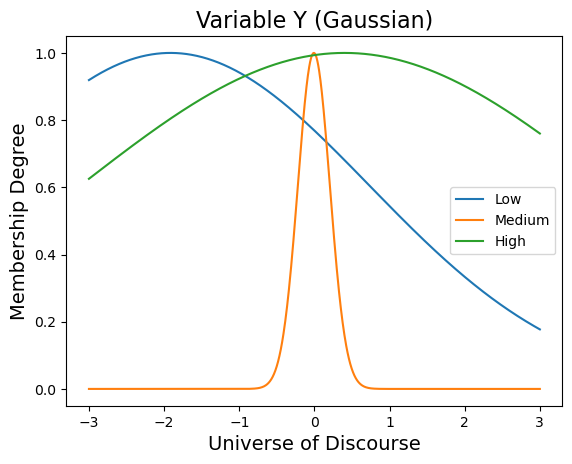

In [16]:
var_name = 'Y'

var_index = anfis.input_var_names.index(var_name)
n_sets = anfis.input_n_sets[var_index]
uod = torch.linspace(-3, 3, 1000).to(device)
mf_names = anfis.input_mf_names[var_index]
mf_function = anfis.memberships[var_index]

memberships = mf_function(uod)

for i in range(n_sets):
    plt.plot(uod.cpu().numpy(), memberships[:, i].detach().cpu().numpy(), label=f'{mf_names[i]}')

plt.title(f'Variable {var_name} (Gaussian)', fontsize=16)
plt.xlabel('Universe of Discourse', fontsize=14)
plt.ylabel('Membership Degree', fontsize=14)
plt.legend()
plt.show()

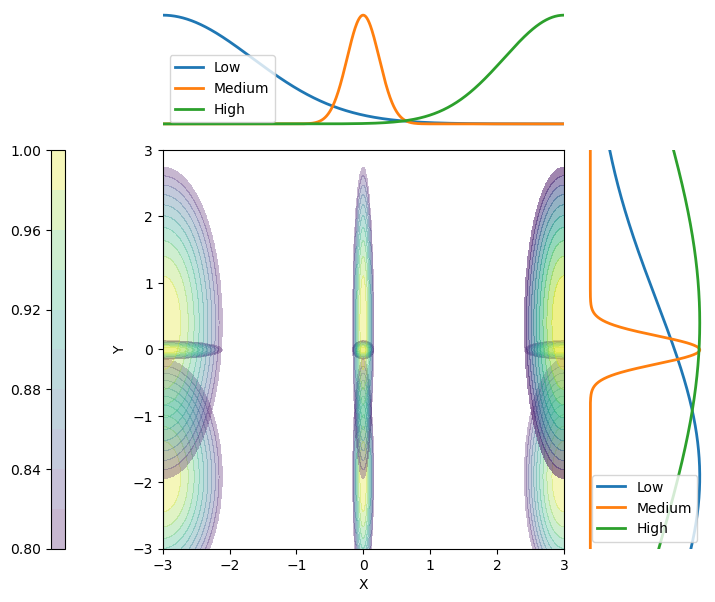

In [17]:
var_names = ['X', 'Y']
n_points=1000
thr=0.8
levels=10
cmap='viridis'
alpha=0.3
x_data=None
y_data=None
file_name=None

var_index = anfis.input_var_names.index(var_names[0])
n_sets0 = anfis.input_n_sets[var_index]
uod0 = torch.linspace(*anfis.input_uod[var_index], n_points).to(device)
mf_names0 = anfis.input_mf_names[var_index]
mf_function0 = anfis.memberships[var_index]

memberships0 = mf_function0(uod0)

var_index = anfis.input_var_names.index(var_names[1])
n_sets1 = anfis.input_n_sets[var_index]
uod1 = torch.linspace(*anfis.input_uod[var_index], n_points).to(device)
mf_names1 = anfis.input_mf_names[var_index]
mf_function1 = anfis.memberships[var_index]

memberships1 = mf_function1(uod1)

x = np.linspace(uod0[0].cpu(), uod0[-1].cpu(), n_points)
y = np.linspace(uod1[0].cpu(), uod1[-1].cpu(), n_points)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(2, 2, width_ratios=[5, 1.5], height_ratios=[1.5, 5], wspace=0.08, hspace=0.08)

ax_main = fig.add_subplot(gs[1, 0])
ax_top = fig.add_subplot(gs[0, 0])
ax_right = fig.add_subplot(gs[1, 1])

for i in range(n_sets0):
    for j in range(n_sets1):
        if anfis.and_operator == torch.prod:
            Z = np.outer(memberships1[:, j].detach().cpu().numpy(), memberships0[:, i].detach().cpu().numpy())
        elif anfis.and_operator == torch.min:
            Z = np.minimum.outer(memberships1[:, j].detach().cpu().numpy(), memberships0[:, i].detach().cpu().numpy())
        Z[Z < thr] = np.nan
        ax_main.contourf(X, Y, Z, levels=levels, cmap=cmap, alpha=alpha)

ax_main.set_xlabel(var_names[0])
ax_main.set_ylabel(var_names[1])

cbar_ax = fig.add_axes([ax_main.get_position().x0 - 0.16,
                ax_main.get_position().y0,
                0.02,
                ax_main.get_position().height])

cbar = fig.colorbar(ax_main.contourf(X, Y, Z, levels=levels, cmap=cmap, alpha=alpha), cax=cbar_ax, orientation="vertical")

cbar.ax.yaxis.set_ticks_position("left")
cbar.ax.yaxis.set_label_position("left")

for i in range(n_sets0):
    ax_top.plot(uod0.cpu(), memberships0[:, i].detach().cpu().numpy(), label=f'{mf_names0[i]}', lw=2)

ax_top.legend()
ax_top.set_xticks([])
ax_top.set_yticks([])

for i in range(n_sets1):
    ax_right.plot(memberships1[:, i].detach().cpu().numpy(), uod1.cpu(), label=f'{mf_names1[i]}', lw=2)

ax_right.legend()
ax_right.set_xticks([])
ax_right.set_yticks([])

ax_top.set_xlim(ax_main.get_xlim())
ax_right.set_ylim(ax_main.get_ylim())

ax_top.set_frame_on(False)
ax_right.set_frame_on(False)

plt.show()

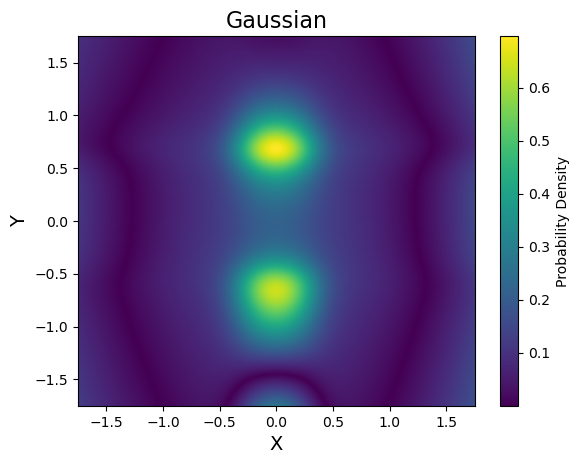

In [18]:
y = anfis(xplot).detach().squeeze()

xi = np.linspace(xplot[:, 0].min(), xplot[:, 0].max(), 100)
yi = np.linspace(xplot[:, 1].min(), xplot[:, 1].max(), 100)
X, Y = np.meshgrid(xi, yi)

Z_sig = np.abs(y.reshape(gridsize, gridsize).detach().numpy())

plt.imshow(Z_sig, extent=[-1.75, 1.75, -1.75, 1.75], origin='lower', aspect='auto')
plt.colorbar(label="Probability Density")
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.title('Gaussian', fontsize=16)
plt.show()

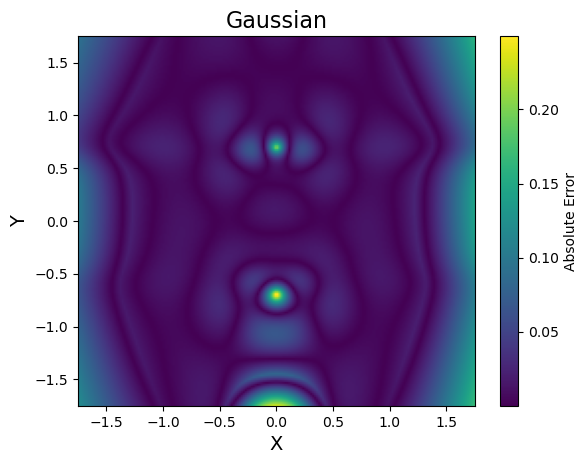

In [19]:
error_sig = np.abs(Z_real - Z_sig)

plt.imshow(error_sig, extent=[-1.75, 1.75, -1.75, 1.75], origin='lower', aspect='auto')
plt.colorbar(label="Absolute Error")
plt.title('Gaussian', fontsize=16)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.show()

## Bell

Loading model.

In [20]:
n_vars = 2
mf_names = [['Low', 'Medium', 'High']]
mfshape = 'bell'

variables = {
    'inputs': {
        'n_sets': [3, 3],
        'uod': n_vars * [(-3, 3)],
        'var_names': ['X', 'Y'],
        'mf_names': n_vars * mf_names,
    },
    'output': {
        'var_names': 'P',
        'n_classes': 1,
    },
}

anfis = ANFIS(
    variables,
    mfshape,
    and_operator=torch.prod,
    output_activation=nn.Identity(),
)

model = torch.load(f'data_{gridsize}/{mfshape}_{gridsize}.pth', map_location=device, weights_only=True)
anfis.load_state_dict(model)

<All keys matched successfully>

Plotting.

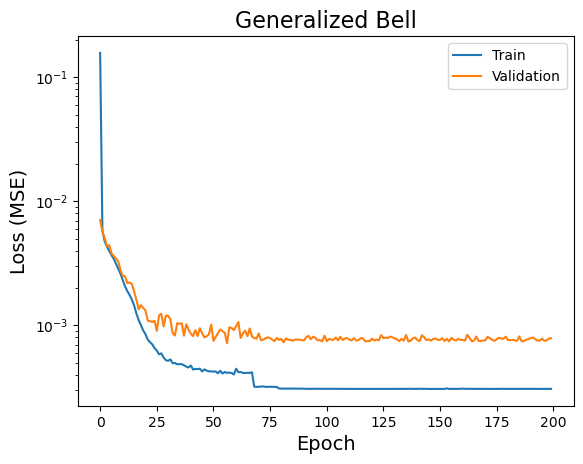

In [21]:
train_losses = np.load(f'data_{gridsize}/train_{mfshape}_{gridsize}.npy')
val_losses = np.load(f'data_{gridsize}/val_{mfshape}_{gridsize}.npy')

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.yscale('log')
plt.legend()
plt.title('Generalized Bell', fontsize=16)
plt.show()

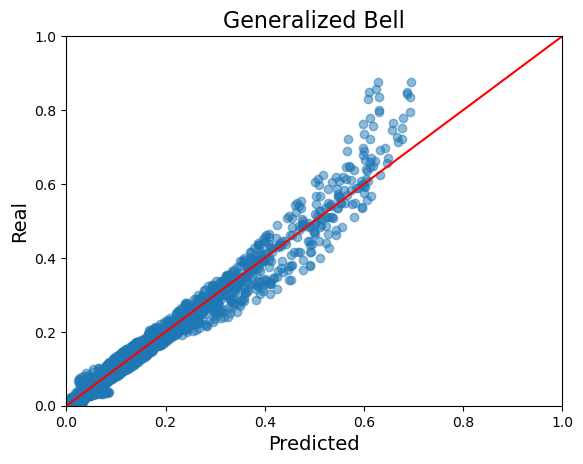

In [22]:
y_pred = torch.abs(anfis(x_test))

plt.scatter(y_pred.detach().cpu(), y_test.detach().cpu(), alpha=0.5)
plt.plot([0, 1], [0, 1], color='red')
plt.ylabel('Real', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.title('Generalized Bell', fontsize=16)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

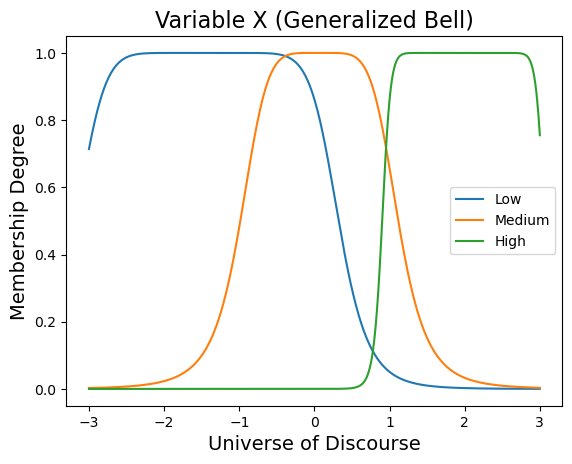

In [23]:
var_name = 'X'

var_index = anfis.input_var_names.index(var_name)
n_sets = anfis.input_n_sets[var_index]
uod = torch.linspace(-3, 3, 1000).to(device)
mf_names = anfis.input_mf_names[var_index]
mf_function = anfis.memberships[var_index]

memberships = mf_function(uod)

for i in range(n_sets):
    plt.plot(uod.cpu().numpy(), memberships[:, i].detach().cpu().numpy(), label=f'{mf_names[i]}')

plt.title(f'Variable {var_name} (Generalized Bell)', fontsize=16)
plt.xlabel('Universe of Discourse', fontsize=14)
plt.ylabel('Membership Degree', fontsize=14)
plt.legend()
plt.show()

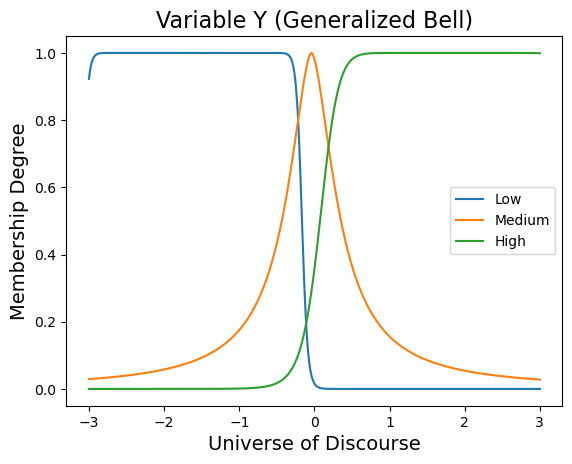

In [24]:
var_name = 'Y'

var_index = anfis.input_var_names.index(var_name)
n_sets = anfis.input_n_sets[var_index]
uod = torch.linspace(-3, 3, 1000).to(device)
mf_names = anfis.input_mf_names[var_index]
mf_function = anfis.memberships[var_index]

memberships = mf_function(uod)

for i in range(n_sets):
    plt.plot(uod.cpu().numpy(), memberships[:, i].detach().cpu().numpy(), label=f'{mf_names[i]}')

plt.title(f'Variable {var_name} (Generalized Bell)', fontsize=16)
plt.xlabel('Universe of Discourse', fontsize=14)
plt.ylabel('Membership Degree', fontsize=14)
plt.legend()
plt.show()

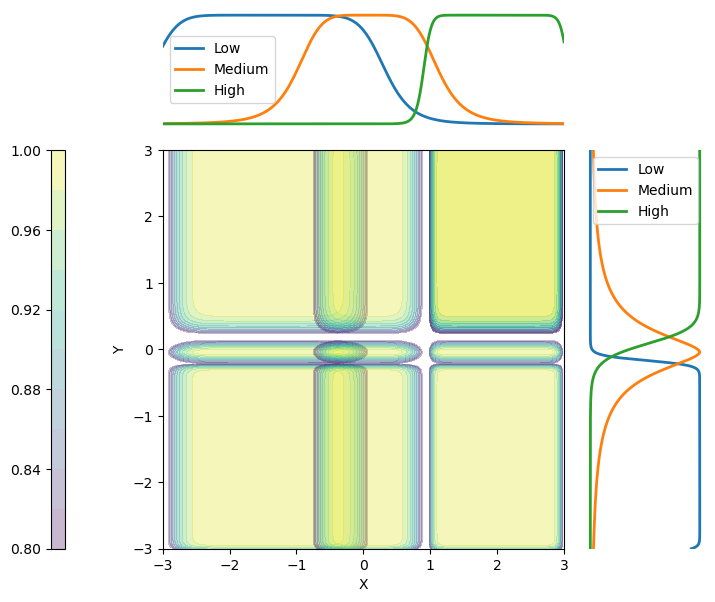

In [25]:
var_names = ['X', 'Y']
n_points=1000
thr=0.8
levels=10
cmap='viridis'
alpha=0.3
x_data=None
y_data=None
file_name=None

var_index = anfis.input_var_names.index(var_names[0])
n_sets0 = anfis.input_n_sets[var_index]
uod0 = torch.linspace(*anfis.input_uod[var_index], n_points).to(device)
mf_names0 = anfis.input_mf_names[var_index]
mf_function0 = anfis.memberships[var_index]

memberships0 = mf_function0(uod0)

var_index = anfis.input_var_names.index(var_names[1])
n_sets1 = anfis.input_n_sets[var_index]
uod1 = torch.linspace(*anfis.input_uod[var_index], n_points).to(device)
mf_names1 = anfis.input_mf_names[var_index]
mf_function1 = anfis.memberships[var_index]

memberships1 = mf_function1(uod1)

x = np.linspace(uod0[0].cpu(), uod0[-1].cpu(), n_points)
y = np.linspace(uod1[0].cpu(), uod1[-1].cpu(), n_points)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(2, 2, width_ratios=[5, 1.5], height_ratios=[1.5, 5], wspace=0.08, hspace=0.08)

ax_main = fig.add_subplot(gs[1, 0])
ax_top = fig.add_subplot(gs[0, 0])
ax_right = fig.add_subplot(gs[1, 1])

for i in range(n_sets0):
    for j in range(n_sets1):
        if anfis.and_operator == torch.prod:
            Z = np.outer(memberships1[:, j].detach().cpu().numpy(), memberships0[:, i].detach().cpu().numpy())
        elif anfis.and_operator == torch.min:
            Z = np.minimum.outer(memberships1[:, j].detach().cpu().numpy(), memberships0[:, i].detach().cpu().numpy())
        Z[Z < thr] = np.nan
        ax_main.contourf(X, Y, Z, levels=levels, cmap=cmap, alpha=alpha)

ax_main.set_xlabel(var_names[0])
ax_main.set_ylabel(var_names[1])

cbar_ax = fig.add_axes([ax_main.get_position().x0 - 0.16,
                ax_main.get_position().y0,
                0.02,
                ax_main.get_position().height])

cbar = fig.colorbar(ax_main.contourf(X, Y, Z, levels=levels, cmap=cmap, alpha=alpha), cax=cbar_ax, orientation="vertical")

cbar.ax.yaxis.set_ticks_position("left")
cbar.ax.yaxis.set_label_position("left")

for i in range(n_sets0):
    ax_top.plot(uod0.cpu(), memberships0[:, i].detach().cpu().numpy(), label=f'{mf_names0[i]}', lw=2)

ax_top.legend()
ax_top.set_xticks([])
ax_top.set_yticks([])

for i in range(n_sets1):
    ax_right.plot(memberships1[:, i].detach().cpu().numpy(), uod1.cpu(), label=f'{mf_names1[i]}', lw=2)

ax_right.legend()
ax_right.set_xticks([])
ax_right.set_yticks([])

ax_top.set_xlim(ax_main.get_xlim())
ax_right.set_ylim(ax_main.get_ylim())

ax_top.set_frame_on(False)
ax_right.set_frame_on(False)

plt.show()

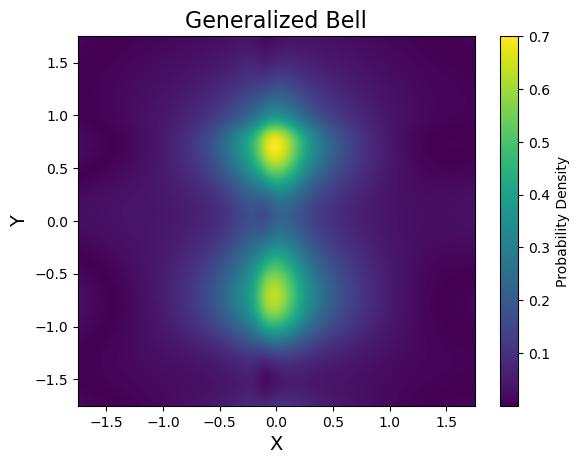

In [26]:
y = anfis(xplot).detach().squeeze()

xi = np.linspace(xplot[:, 0].min(), xplot[:, 0].max(), gridsize)
yi = np.linspace(xplot[:, 1].min(), xplot[:, 1].max(), gridsize)
X, Y = np.meshgrid(xi, yi)

Z_sig = np.abs(y.reshape(gridsize, gridsize).detach().numpy())

plt.imshow(Z_sig, extent=[-1.75, 1.75, -1.75, 1.75], origin='lower', aspect='auto')
plt.colorbar(label="Probability Density")
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.title('Generalized Bell', fontsize=16)
plt.show()

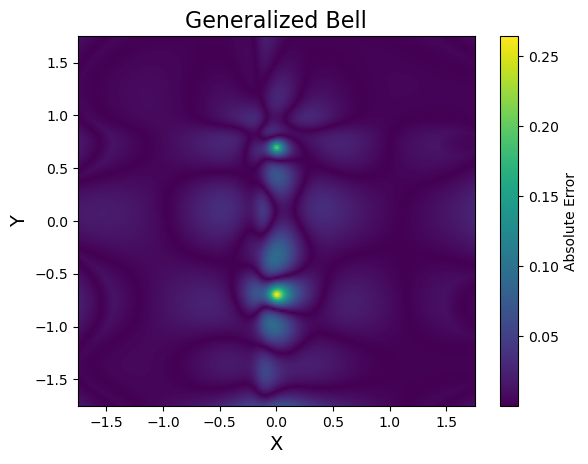

In [27]:
error_sig = np.abs(Z_real - Z_sig)

plt.imshow(error_sig, extent=[-1.75, 1.75, -1.75, 1.75], origin='lower', aspect='auto')
plt.colorbar(label="Absolute Error")
plt.title('Generalized Bell', fontsize=16)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.show()

## ANN

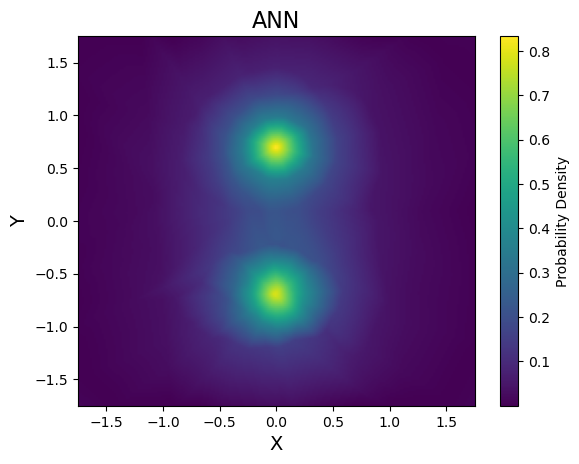

In [28]:
class ANN(nn.Module):
    def __init__(self, input_dim):  
        super(ANN, self).__init__()  
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ann = ANN(2).to(device)

ann = torch.load("ann.pt", map_location=device, weights_only=False)
ann.eval()

with open(f"data_{gridsize}/{gridsize}_data.pkl", "rb") as f:
    data = pickle.load(f)

gx, gy = data['gx'].ravel(), data['gy'].ravel()

x = np.stack((gx, gy), axis=1)
y = data['ps'].ravel()

SEED = 42

x, index = np.unique(x, axis=0, return_index=True)
y = y[index]

x_original = torch.tensor(x, dtype=torch.float32)
y_original = torch.tensor(y, dtype=torch.float32)

y = ann(x_original).detach().squeeze()

xor_mean = x_original.mean(dim=0)
xor_std = x_original.std(dim=0)

x_original = (x_original - xor_mean) / xor_std

xi = np.linspace(x_original[:, 0].min(), x_original[:, 0].max(), gridsize)
yi = np.linspace(x_original[:, 1].min(), x_original[:, 1].max(), gridsize)
X, Y = np.meshgrid(xi, yi)

Z_ann = np.abs(y.reshape(gridsize, gridsize).detach().numpy())

plt.imshow(Z_ann, extent=[-1.75, 1.75, -1.75, 1.75], origin='lower', aspect='auto')
plt.colorbar(label="Probability Density")
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.title('ANN', fontsize=16)
plt.show()

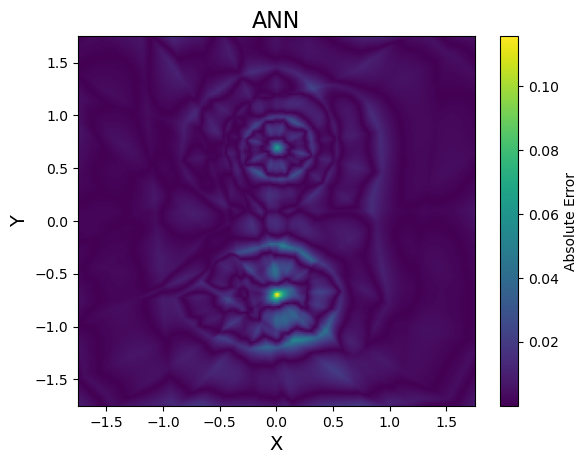

In [29]:
plt.imshow(np.abs(Z_real - Z_ann), extent=[-1.75, 1.75, -1.75, 1.75], origin='lower', aspect='auto')
plt.colorbar(label="Absolute Error")
plt.title('ANN', fontsize=16)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.show()